In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [3]:
# # 大庆市
roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# # 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# # 武汉市
# roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# # 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
# roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,8)

In [4]:
elevation = ee.Image('USGS/SRTMGL1_003').select('elevation').clip(roi)
def maskSR(image):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = image.get('SOLAR_AZIMUTH_ANGLE')
    zenith = image.get('SOLAR_ZENITH_ANGLE')
    return image.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True))
# 图像可视化参数
visParams = {'bands': ['B5', 'B6', 'B4'],'min': 0,'max': 3000,'gamma': 1.4}

# landsat8

## 定义函数

In [ ]:
def detect_outlier(image):
    a = image.clip(roi).lt(0)
    max = a.reduceRegion(**{'reducer': ee.Reducer.max(),'geometry': roi,'scale': 30,'maxPixels': 1e14})
    number = ee.Number(max.get('B2')).add(ee.Number(max.get('B3'))).add(ee.Number(max.get('B4'))).add(ee.Number(max.get('B5'))).add(ee.Number(max.get('B6'))).add(ee.Number(max.get('B7')))
    return image.set({'outlier': number}).set({'outlier_B2': max.get('B2')}).set({'outlier_B3': max.get('B3')}).set({'outlier_B4': max.get('B4')}).set({'outlier_B5': max.get('B5')}).set({'outlier_B6': max.get('B6')}).set({'outlier_B7': max.get('B7')})

# def detect_outlier(image):
#     a = image.clip(roi).lt(0)
#     max = a.reduceRegion(**{'reducer': ee.Reducer.max(),'geometry': roi,'scale': 30,'maxPixels': 1e14,'tileScale': 4})
#     return image.set({'outlier': max.get('B2')})

In [ ]:
def outlier_images(year):
    start = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-01-01'))
    end = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-12-31'))
    landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    bands = landsat_images.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa'])
    dataset = bands.map(detect_outlier).filter(ee.Filter.gt('outlier',0))   
    return dataset.size()

def normal_images(year):
    start = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-01-01'))
    end = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-12-31'))
    landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    bands = landsat_images.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa'])
    dataset = bands.map(detect_outlier).filter(ee.Filter.lte('outlier',0))   
    return dataset.size()

def l8(year):
    start = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-01-01'))
    end = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-12-31'))
    dataset = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    return dataset.size()

## 计算

In [ ]:
import numpy as np
for i in np.arange(2019,2021,1):
    print(outlier_images(int(i)).getInfo())

import numpy as np
for i in np.arange(2013,2021,1):
    print(normal_images(int(i)).getInfo())

import numpy as np
for i in np.arange(2013,2021,1):
    print(l8(int(i)).getInfo())

In [ ]:
a = ee.List.sequence(2013,2020,1)
outlier = a.map(outlier_images).getInfo()
print(outlier)

normal = a.map(normal_images).getInfo()
print(normal)

l8_images = a.map(l8).getInfo()
print(l8_images)

## 绘图

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
x = np.arange(2013,2021)
plt.figure(figsize=(8, 6))
plt.bar(x, normal, width=0.45,align="center",label="normal images")
plt.bar(x, outlier, width=0.45, align="center", bottom=normal, label="abnormal images")
# plt.bar(x, l8, width=0.45, align="center", bottom=l7, label="Landsat8")

plt.ylim(0,160)
plt.xlabel("Year",size=20)
plt.ylabel("Number of images",size=20)
plt.tick_params(labelsize=15)
# plt.xticks([2013,2020])
plt.yticks([50,100,150])
plt.legend(prop={'size':24},markerscale=20)
plt.title('Region D',size=24)

plt.show()

In [ ]:
# region a 
[58, 75, 78, 74, 71, 76, 80, 64]
[9, 14, 7, 6, 17, 6, 9, 7]
[67, 89, 85, 80, 88, 82, 89, 71]

# region b
[44, 72, 59, 74, 87, 92, 82, 90]
[40, 47, 57, 49, 33, 38, 35, 20]
[84, 119, 116, 123, 120, 130, 117, 110]

# region c
[39, 33, 41, 48, 46, 54, 54, 38]
[14, 20, 24, 17, 21, 12, 6, 7]
[53, 53, 65, 65, 67, 66, 60, 45]

# region d
[39, 60, 63, 60, 69, 63, 65, 69]
[9, 27, 26, 30, 31, 31, 25, 20]
[48, 87, 89, 90, 100, 94, 90, 89]

# region e
[78, 112, 121, 116, 116, 117, 119, 115]
[11, 17, 12, 14, 15, 17, 10, 9]
[89, 129, 133, 130, 131, 134, 129, 124]

# landsat7

## 定义函数

In [ ]:
def detect_outlier(image):
    a = image.clip(roi).lt(0)
    max = a.reduceRegion(**{'reducer': ee.Reducer.max(),'geometry': roi,'scale': 30,'maxPixels': 1e14})
    number = ee.Number(max.get('B2')).add(ee.Number(max.get('B3'))).add(ee.Number(max.get('B4'))).add(ee.Number(max.get('B5'))).add(ee.Number(max.get('B6'))).add(ee.Number(max.get('B7')))
    return image.set({'outlier': number}).set({'outlier_B2': max.get('B2')}).set({'outlier_B3': max.get('B3')}).set({'outlier_B4': max.get('B4')}).set({'outlier_B5': max.get('B5')}).set({'outlier_B6': max.get('B6')}).set({'outlier_B7': max.get('B7')})


In [ ]:
def outlier_images(year):
    start = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-01-01'))
    end = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-12-31'))
    landsat_images = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    bands = landsat_images.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa'])
    dataset = bands.map(detect_outlier).filter(ee.Filter.gt('outlier',0))   
    return dataset.size()

def normal_images(year):
    start = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-01-01'))
    end = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-12-31'))
    landsat_images = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    bands = landsat_images.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa'])
    dataset = bands.map(detect_outlier).filter(ee.Filter.lte('outlier',0))   
    return dataset.size()

def l8(year):
    start = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-01-01'))
    end = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-12-31'))
    dataset = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    return dataset.size()

## 计算

In [ ]:
import numpy as np
for i in np.arange(2000,2021,1):
    print(outlier_images(int(i)).getInfo())

import numpy as np
for i in np.arange(2000,2021,1):
    print(normal_images(int(i)).getInfo())

import numpy as np
for i in np.arange(2000,2021,1):
    print(l8(int(i)).getInfo())

In [ ]:
a = ee.List.sequence(2000,2020,1)
outlier = a.map(outlier_images).getInfo()
print(outlier)

normal = a.map(normal_images).getInfo()
print(normal)

l8_images = a.map(l8).getInfo()
print(l8_images)

## 绘图

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
x = np.arange(2000,2021)
plt.figure(figsize=(8, 6))
plt.bar(x, normal, width=0.45,align="center",label="normal images")
plt.bar(x, outlier, width=0.45, align="center", bottom=normal, label="abnormal images")
# plt.bar(x, l8, width=0.45, align="center", bottom=l7, label="Landsat8")

plt.ylim(0,150)
plt.xlabel("Year",size=20)
plt.ylabel("Number of images",size=20)
plt.tick_params(labelsize=15)
plt.xticks([2000,2005,2010,2015,2020])
plt.yticks([50,100,150])
# plt.legend(prop={'size':24},markerscale=20)
plt.title('Region A',size=24)
plt.show()

In [ ]:
# region a 
[78, 80, 81, 52, 68, 66, 61, 78, 69, 49, 56, 59, 62, 47, 67, 61, 63, 62, 61, 70, 54]
[10, 18, 15, 14, 20, 7, 11, 13, 17, 17, 11, 12, 12, 6, 10, 11, 5, 12, 8, 17, 14]
[88, 98, 96, 66, 88, 73, 72, 91, 86, 66, 67, 71, 74, 53, 77, 72, 68, 74, 69, 87, 68]

# region b
[81, 98, 88, 61, 68, 65, 56, 63, 42, 43, 44, 49, 59, 91, 94, 84, 79, 93, 95, 80, 94]
[25, 24, 23, 25, 38, 40, 47, 48, 69, 51, 38, 50, 46, 23, 24, 23, 23, 13, 18, 21, 15]
[106, 122, 111, 86, 106, 105, 103, 111, 111, 94, 82, 99, 105, 114, 118, 107, 102, 106, 113, 101, 109]

# region c
[32, 44, 43, 33, 45, 35, 31, 25, 34, 27, 26, 30, 28, 42, 33, 39, 42, 39, 38, 37, 38]
[5, 4, 3, 5, 2, 4, 11, 13, 5, 12, 10, 8, 5, 2, 1, 6, 2, 0, 0, 0, 2]
[37, 48, 46, 38, 47, 39, 42, 38, 39, 39, 36, 38, 33, 44, 34, 45, 44, 39, 38, 37, 40]

# region d
[50, 48, 53, 39, 66, 46, 45, 49, 52, 50, 33, 50, 33, 61, 54, 49, 47, 53, 57, 57, 61]
[20, 18, 17, 10, 14, 11, 5, 11, 17, 18, 15, 21, 18, 2, 10, 15, 7, 11, 14, 7, 10]
[70, 66, 70, 49, 80, 57, 50, 60, 69, 68, 48, 71, 51, 63, 64, 64, 54, 64, 71, 64, 71]

# region e
outlier = [43, 55, 51, 43, 59, 59, 47, 57, 38, 57, 58, 49, 64, 93, 101, 110, 103, 98, 112, 103, 107]
normal = [13, 14, 12, 11, 20, 13, 18, 12, 17, 14, 11, 14, 24, 7, 15, 16, 13, 15, 14, 8, 13]
total = [56, 69, 63, 54, 79, 72, 65, 69, 55, 71, 69, 63, 88, 100, 116, 126, 116, 113, 126, 111, 120]

# Landsat5

## 定义函数

In [ ]:
def detect_outlier(image):
    a = image.clip(roi).lt(0)
    max = a.reduceRegion(**{'reducer': ee.Reducer.max(),'geometry': roi,'scale': 30,'maxPixels': 1e14})
    number = ee.Number(max.get('B2')).add(ee.Number(max.get('B3'))).add(ee.Number(max.get('B4'))).add(ee.Number(max.get('B5'))).add(ee.Number(max.get('B6'))).add(ee.Number(max.get('B7')))
    return image.set({'outlier': number}).set({'outlier_B2': max.get('B2')}).set({'outlier_B3': max.get('B3')}).set({'outlier_B4': max.get('B4')}).set({'outlier_B5': max.get('B5')}).set({'outlier_B6': max.get('B6')}).set({'outlier_B7': max.get('B7')})


In [ ]:
def outlier_images(year):
    start = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-01-01'))
    end = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-12-31'))
    landsat_images = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    bands = landsat_images.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa'])
    dataset = bands.map(detect_outlier).filter(ee.Filter.gt('outlier',0))   
    return dataset.size()

def normal_images(year):
    start = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-01-01'))
    end = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-12-31'))
    landsat_images = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    bands = landsat_images.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa'])
    dataset = bands.map(detect_outlier).filter(ee.Filter.lte('outlier',0))   
    return dataset.size()

def l8(year):
    start = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-01-01'))
    end = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-12-31'))
    dataset = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    return dataset.size()

## 计算

In [ ]:
import numpy as np
for i in np.arange(2000,2013,1):
    print(outlier_images(int(i)).getInfo())

import numpy as np
for i in np.arange(2000,2013,1):
    print(normal_images(int(i)).getInfo())

import numpy as np
for i in np.arange(2000,2013,1):
    print(l8(int(i)).getInfo())

In [ ]:
a = ee.List.sequence(2000,2012,1)
outlier = a.map(outlier_images).getInfo()
print(outlier)

normal = a.map(normal_images).getInfo()
print(normal)

l8_images = a.map(l8).getInfo()
print(l8_images)

## 绘图

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
x = np.arange(2000,2012)
plt.figure(figsize=(8, 6))
plt.bar(x, normal, width=0.45,align="center",label="normal images")
plt.bar(x, outlier, width=0.45, align="center", bottom=normal, label="abnormal images")
# plt.bar(x, l8, width=0.45, align="center", bottom=l7, label="Landsat8")

plt.ylim(0,160)
plt.xlabel("Year",size=20)
plt.ylabel("Number of images",size=20)
plt.tick_params(labelsize=15)
# plt.xticks([2013,2020])
plt.yticks([50,100,150])
plt.legend(prop={'size':24},markerscale=20)
plt.title('Region D',size=24)

plt.show()

In [ ]:
# region a 
[69, 77, 62, 74, 83, 68, 75, 71, 51, 69, 56, 45]
[25, 15, 6, 2, 7, 1, 6, 4, 5, 5, 8, 13]
[94, 92, 68, 76, 90, 69, 81, 75, 56, 74, 64, 58]

# region b
[57, 65, 59, 55, 83, 67, 78, 61, 60, 80, 69, 53]
[42, 47, 21, 23, 21, 22, 21, 14, 12, 16, 24, 22]
[99, 112, 80, 78, 104, 89, 99, 75, 72, 96, 93, 75]

# region c
[26, 37, 32, 41, 46, 37, 38, 37, 41, 43, 32, 33]
[7, 4, 3, 0, 0, 0, 0, 0, 0, 0, 1, 2]
[33, 41, 35, 41, 46, 37, 38, 37, 41, 43, 33, 35]

# region d
[58, 52, 38, 74, 90, 65, 65, 58, 67, 83, 37, 44]
[13, 7, 3, 0, 3, 0, 2, 2, 1, 1, 4, 5]
[71, 59, 41, 74, 93, 65, 67, 60, 68, 84, 41, 49]

# region e
[71, 82, 81, 93, 109, 89, 100, 77, 73, 106, 101, 65]
[17, 33, 7, 5, 4, 2, 3, 0, 1, 3, 10, 14]
[88, 115, 88, 98, 113, 91, 103, 77, 74, 109, 111, 79]

# 合并绘图

In [20]:
# # # region a 
# outlier8 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 58, 75, 78, 74, 71, 76, 80, 64]
# normal8 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 14, 7, 6, 17, 6, 9, 7]
# outlier7 = [18, 78, 80, 81, 52, 68, 66, 61, 78, 69, 49, 56, 59, 62, 47, 67, 61, 63, 62, 61, 70, 54]
# normal7 = [3, 10, 18, 15, 14, 20, 7, 11, 13, 17, 17, 11, 12, 12, 6, 10, 11, 5, 12, 8, 17, 14]
# outlier5 = [73, 69, 77, 62, 74, 83, 68, 75, 71, 51, 69, 56, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# normal5 = [12, 25, 15, 6, 2, 7, 1, 6, 4, 5, 5, 8, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# # region b
# outlier8 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 44, 72, 59, 74, 87, 92, 82, 90]
# normal8 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 47, 57, 49, 33, 38, 35, 20]
# outlier7 = [26, 81, 98, 88, 61, 68, 65, 56, 63, 42, 43, 44, 49, 59, 91, 94, 84, 79, 93, 95, 80, 94]
# normal7 = [4, 25, 24, 23, 25, 38, 40, 47, 48, 69, 51, 38, 50, 46, 23, 24, 23, 23, 13, 18, 21, 15]
# outlier5 = [69, 57, 65, 59, 55, 83, 67, 78, 61, 60, 80, 69, 53, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# normal5 = [33, 42, 47, 21, 23, 21, 22, 21, 14, 12, 16, 24, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# # region c
# outlier8 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 33, 41, 48, 46, 54, 54, 38]
# normal8 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 20, 24, 17, 21, 12, 6, 7]
# outlier7 = [7, 32, 44, 43, 33, 45, 35, 31, 25, 34, 27, 26, 30, 28, 42, 33, 39, 42, 39, 38, 37, 38]
# normal7 = [0, 5, 4, 3, 5, 2, 4, 11, 13, 5, 12, 10, 8, 5, 2, 1, 6, 2, 0, 0, 0, 2]
# outlier5 = [26, 26, 37, 32, 41, 46, 37, 38, 37, 41, 43, 32, 33, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# normal5 = [4, 7, 4, 3, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# # region d
# outlier8 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 60, 63, 60, 69, 63, 65, 69]
# normal8 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 27, 26, 30, 31, 31, 25, 20]
# outlier7 = [12, 50, 48, 53, 39, 66, 46, 45, 49, 52, 50, 33, 50, 33, 61, 54, 49, 47, 53, 57, 57, 61]
# normal7 = [4, 20, 18, 17, 10, 14, 11, 5, 11, 17, 18, 15, 21, 18, 2, 10, 15, 7, 11, 14, 7, 10]
# outlier5 = [52, 58, 52, 38, 74, 90, 65, 65, 58, 67, 83, 37, 44, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# normal5 = [16, 13, 7, 3, 0, 3, 0, 2, 2, 1, 1, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# region e
outlier8 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 78, 112, 121, 116, 116, 117, 119, 115]
normal8 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 17, 12, 14, 15, 17, 10, 9]
outlier7 = [12, 43, 55, 51, 43, 59, 59, 47, 57, 38, 57, 58, 49, 64, 93, 101, 110, 103, 98, 112, 103, 107]
normal7 = [0, 13, 14, 12, 11, 20, 13, 18, 12, 17, 14, 11, 14, 24, 7, 15, 16, 13, 15, 14, 8, 13]
outlier5 = [53, 71, 82, 81, 93, 109, 89, 100, 77, 73, 106, 101, 65, 0, 0, 0, 0, 0, 0, 0, 0, 0]
normal5 = [17, 17, 33, 7, 5, 4, 2, 3, 0, 1, 3, 10, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [21]:
cum57 = list(map(sum, zip(list(normal5),list(normal7))))
print(cum57)
cum578 = list(map(sum, zip(list(normal5),list(normal7),list(normal8))))
print(cum578)
cum5785 = list(map(sum, zip(list(normal5),list(normal7),list(normal8),list(outlier5))))
print(cum5785)
cum57857 = list(map(sum, zip(list(normal5),list(normal7),list(normal8),list(outlier5),list(outlier7))))
print(cum57857)
# cum578578 = list(map(sum, zip(list(normal5),list(normal7),list(normal8),list(outlier5),list(outlier7),list(outlier8))))
# print(cum578578)

[17, 30, 47, 19, 16, 24, 15, 21, 12, 18, 17, 21, 28, 24, 7, 15, 16, 13, 15, 14, 8, 13]
[17, 30, 47, 19, 16, 24, 15, 21, 12, 18, 17, 21, 28, 24, 18, 32, 28, 27, 30, 31, 18, 22]
[70, 101, 129, 100, 109, 133, 104, 121, 89, 91, 123, 122, 93, 24, 18, 32, 28, 27, 30, 31, 18, 22]
[82, 144, 184, 151, 152, 192, 163, 168, 146, 129, 180, 180, 142, 88, 111, 133, 138, 130, 128, 143, 121, 129]


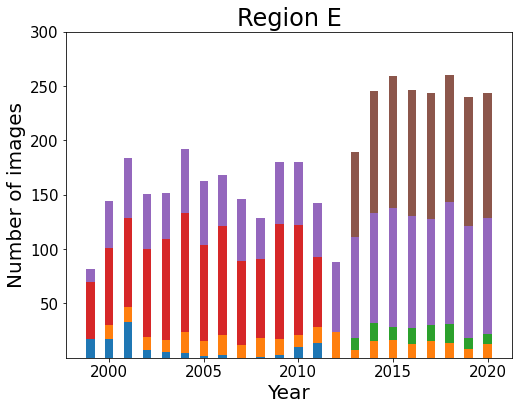

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
x = np.arange(1999,2021)
plt.figure(figsize=(8, 6))
plt.bar(x, normal5, width=0.45,align="center",label="landsat5-normal")
plt.bar(x, normal7, width=0.45, align="center", bottom=normal5, label="landsat7-normal")
plt.bar(x, normal8, width=0.45, align="center", bottom=cum57, label="landsat8-normal")
plt.bar(x, outlier5, width=0.45, align="center", bottom=cum578, label="landsat5-abnormal")
plt.bar(x, outlier7, width=0.45, align="center", bottom=cum5785, label="landsat7-abnormal")
plt.bar(x, outlier8, width=0.45, align="center", bottom=cum57857, label="landsat8-abnormal")


plt.ylim(0,300)
plt.xlabel("Year",size=20)
plt.ylabel("Number of images",size=20)
plt.tick_params(labelsize=15)
plt.xticks([2000,2005,2010,2015,2020])
plt.yticks([50,100,150,200,250,300])
# plt.legend(prop={'size':20},markerscale=15)
plt.title('Region E',size=24)
plt.show()

# 附录

In [ ]:
def detect_outlier(image):
    a = image.clip(roi).lt(0)
    max = a.reduceRegion(**{'reducer': ee.Reducer.max(),'geometry': roi,'scale': 30,'maxPixels': 1e14})
    number = ee.Number(max.get('B2')).add(ee.Number(max.get('B3'))).add(ee.Number(max.get('B4'))).add(ee.Number(max.get('B5'))).add(ee.Number(max.get('B6'))).add(ee.Number(max.get('B7')))
    return image.set({'outlier': number})

# 定义参数
year = '2020'
startDate = year + '-01-01'
endDate = year + '-12-31'

l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate(startDate, endDate)

a = l8.map(detect_outlier)
print(l8.size().getInfo())
print(a.filter(ee.Filter.gt('outlier',0)).size().getInfo())
print(a.filter(ee.Filter.lt('outlier',1)).size().getInfo())
print(a.aggregate_array('outlier').getInfo())

In [ ]:
def detect_outlier(image):
    a = image.clip(roi).lt(0)
    max = a.reduceRegion(**{'reducer': ee.Reducer.max(),'geometry': roi,'scale': 30,'maxPixels': 1e14})
    number = ee.Number(max.get('B2')).add(ee.Number(max.get('B3'))).add(ee.Number(max.get('B4'))).add(ee.Number(max.get('B5'))).add(ee.Number(max.get('B6'))).add(ee.Number(max.get('B7')))
    return image.set({'outlier': number}).set({'outlier_B2': max.get('B2')}).set({'outlier_B3': max.get('B3')}).set({'outlier_B4': max.get('B4')}).set({'outlier_B5': max.get('B5')}).set({'outlier_B6': max.get('B6')}).set({'outlier_B7': max.get('B7')})

# 定义参数
year = '2020'
startDate = year + '-01-01'
endDate = year + '-12-31'

l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate(startDate, endDate)

a = l8.map(detect_outlier)
print(l8.size().getInfo())
print(a.filter(ee.Filter.gt('outlier',0)).size().getInfo())
print(a.filter(ee.Filter.lt('outlier',1)).size().getInfo())
print(a.aggregate_array('outlier').getInfo())

In [ ]:
image = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_138035_20200101').clip(roi)
Map.addLayer(image.clip(roi),visParams,'image')
mask_image = maskSR(image)
Map.addLayer(mask_image.clip(roi),visParams,'mask image')

In [ ]:
outlier = image.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']).lt(0)
max = outlier.reduceRegion(**{'reducer': ee.Reducer.max(),'geometry': roi,'scale': 30,'maxPixels': 1e14})
print(max.getInfo())

Map.addLayer(outlier,{'palette':['white','red'],'min':0,'max':1},"outlier")